In [5]:
import sys
#!{sys.executable} -m pip install mlxtend
#!{sys.executable} -m pip install networkx

In [6]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark_dist_explore import hist
from pyspark.sql.functions import size, count, mean, stddev, when, min, max, col, desc, asc, concat, lit, concat_ws, to_date, unix_timestamp, collect_list, regexp_replace
from pyspark.sql.window import Window
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType, DateType, StructType, StructField
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.fpm import FPGrowth

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import networkx as nx
import time

from IPython.display import Audio

In [7]:
#Para que avise cuando termine una ejecución
def beep():
    return Audio(np.sin(np.pi*100*np.arange(1000*2)/1000),rate=10000, autoplay=True)

## Parámetros

In [8]:
bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket')
print(bucket)

pry_spsa


In [9]:
todays_date = '2019_02_18_13_39_11'
bucket_name = "datasets_prueba"
datafr_name = "local"
bucket_path = "gs://{}/{}/{}/{}".format(bucket, bucket_name, datafr_name, todays_date)
print(bucket_path)

#cuentas = "6043560006358567,6043566000042602" #,6043566011632193,6043566013687724,6043566001838552"

gs://pry_spsa/datasets_prueba/local/2019_02_18_13_39_11


In [6]:
#sc.getConf().getAll()
#sc.stop()
#
#conf = SparkConf().setAppName("pysparkPropCuentCateg")
#conf = (conf.setMaster('yarn')
#        .set('spark.executor.cores', '4')     # Cores por maquina
#        .set('spark.executor.memory', '10G')  # memoria de cada maquina (debe ser menor)
#        .set('spark.executor.instances', '4') # cantidad de maquinas
#        #.set('spark.driver.memory', '15G')   # No tocar a menos que sea necesario
#        #.set('spark.driver.maxResultSize', '10G')
#       )
#sc = SparkContext(conf=conf)

In [10]:
#sc = SparkContext()
sc.setCheckpointDir("gs://{}/tmp/PropClusterCateg".format(bucket))
spark = SparkSession(sc)
sc

<SparkContext master=yarn appName=pyspark-shell>

## Recuperación Spark

In [11]:
parquet_files = "{}/part-*.snappy.parquet".format(bucket_path)
print(parquet_files)

#sdf = spark.read.parquet(parquet_files).filter('codigo_cuenta in (' + cuentas + ')')
sdf = spark.read.parquet(parquet_files)

gs://pry_spsa/datasets_prueba/local/2019_02_18_13_39_11/part-*.snappy.parquet


In [12]:
sdf = sdf.dropna(how='any')
sdf.count()

55215170

In [13]:
# Cambio a enteros los datos de fechas
# hice una modificación desde la ingesta que falta por probar
# si todo sale bien, esta celda se podría elimnar

sdf = sdf.withColumn('anio_calendario', sdf.anio_calendario.cast(IntegerType()))
sdf = sdf.withColumn('nro_mes_anio', sdf.nro_mes_anio.cast(IntegerType()))
sdf = sdf.withColumn('nro_dia_mes', sdf.nro_dia_mes.cast(IntegerType()))
sdf = sdf.withColumn('nro_dia_anio', sdf.nro_dia_anio.cast(IntegerType()))
sdf = sdf.withColumn('nro_semana_anio', sdf.nro_semana_anio.cast(IntegerType()))
sdf = sdf.withColumn('trimestre_calendario', sdf.trimestre_calendario.cast(IntegerType()))
sdf = sdf.withColumn('semestre_calendario', sdf.semestre_calendario.cast(IntegerType()))
#sdf = sdf.withColumn('fecha',concat(col('nro_dia_mes'),col('nro_mes_anio'),col('anio_calendario'))).cast(DateType())

sdf = sdf.withColumn("concat", concat_ws("-", col("anio_calendario"), col("nro_mes_anio"), col("nro_dia_mes")))
sdf = sdf.withColumn("fecha", to_date(unix_timestamp(col("concat"), "yyyy-MM-dd").cast("timestamp")))
sdf = sdf.drop("concat")

sdf.printSchema()

root
 |-- anio_calendario: integer (nullable = true)
 |-- categoria: string (nullable = true)
 |-- cluster: string (nullable = true)
 |-- codigo_cuenta: string (nullable = true)
 |-- codigo_producto: string (nullable = true)
 |-- costo_kardex: double (nullable = true)
 |-- margen: double (nullable = true)
 |-- monto_dscto_producto: double (nullable = true)
 |-- nro_dia_anio: integer (nullable = true)
 |-- nro_dia_mes: integer (nullable = true)
 |-- nro_mes_anio: integer (nullable = true)
 |-- nro_semana_anio: integer (nullable = true)
 |-- seccion_dia_compra: string (nullable = true)
 |-- semestre_calendario: integer (nullable = true)
 |-- trimestre_calendario: integer (nullable = true)
 |-- venta_bruta: double (nullable = true)
 |-- venta_neta: double (nullable = true)
 |-- venta_total: double (nullable = true)
 |-- venta_unidad: double (nullable = true)
 |-- fecha: date (nullable = true)



In [14]:
# Selección de variables de interés

sdf = sdf.select("codigo_cuenta","anio_calendario","nro_mes_anio","codigo_producto")
#sdf = sdf.select("codigo_cuenta","fecha","categoria")

#sdf = sdf.select("codigo_cuenta","fecha","seccion_dia_compra","categoria")

In [15]:
sdf.show(200)

+----------------+---------------+------------+---------------+
|   codigo_cuenta|anio_calendario|nro_mes_anio|codigo_producto|
+----------------+---------------+------------+---------------+
|6043566000167888|           2018|           1|    00020061231|
|6043566000553558|           2018|           1|    00020131436|
|6043567000215909|           2018|           1|    00000931241|
|6043566011174584|           2018|           1|    00020064433|
|6043567000215909|           2018|           1|    00020086602|
|6043566009247129|           2018|           1|    00000848879|
|6043567000215909|           2018|           1|    00000128186|
|6043566012799058|           2018|           1|    00000952064|
|6043566011774268|           2018|           1|    00020120398|
|6043566011493612|           2018|           1|    00000115270|
|6043566000044020|           2018|           1|    00000118819|
|6043566013702937|           2018|           1|    00000376396|
|6043566010750707|           2018|      

In [16]:
# selección de casos únicos

gdf = sdf.withColumn('codigo_producto', regexp_replace(col('codigo_producto'), "\\|", "-"))
#gdf = gdf.groupBy("codigo_cuenta","categoria").agg(count("categoria"))
#gdf = gdf.groupBy("codigo_cuenta","fecha","categoria").agg(count("categoria"))
gdf = gdf.groupBy("codigo_cuenta","anio_calendario","nro_mes_anio","codigo_producto").agg(count("codigo_producto"))

gdf.show(100, truncate=False)

+----------------+---------------+------------+---------------+----------------------+
|codigo_cuenta   |anio_calendario|nro_mes_anio|codigo_producto|count(codigo_producto)|
+----------------+---------------+------------+---------------+----------------------+
|6043566001851332|2018           |2           |00000051946    |1                     |
|6043566012394918|2018           |2           |00020138395    |1                     |
|6043566007340124|2018           |2           |20021925002    |1                     |
|6043566006348391|2018           |2           |00020082055    |1                     |
|6043566000974051|2018           |2           |00000993067    |1                     |
|6043566010412282|2018           |2           |00000135238    |1                     |
|6043566010277701|2018           |2           |00000108843    |1                     |
|6043566010954085|2018           |2           |00020012891    |1                     |
|6043566013633744|2018           |2        

In [17]:
# Agrupación de subfamilias compradas por cuenta

#ndf = gdf.groupBy("codigo_cuenta").agg(collect_list("categoria").alias("items"))
#ndf = gdf.groupBy("codigo_cuenta","fecha").agg(collect_list("categoria").alias("items"))
ndf = gdf.groupBy("codigo_cuenta","anio_calendario","nro_mes_anio").agg(collect_list("codigo_producto").alias("items"))

ndf.show(10, truncate=False)

+----------------+---------------+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|codigo_cuenta   |anio_calendario|nro_mes_anio|items                                                                                                          

In [18]:
transacciones = ndf.count()
transacciones

2175376

In [19]:
start = time.time()

In [20]:
# Aplicación algoritmo de patrones más frecuentes

#fpGrowth = FPGrowth(itemsCol="items", minSupport=0.2, minConfidence=0.2)
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.05, minConfidence=0.05)
model = fpGrowth.fit(ndf)

In [21]:
# Display frequent itemsets.
#model.freqItemsets.orderBy(desc('freq')).show(truncate=False)
model.freqItemsets.show(10,truncate=False)

+--------------------------+------+
|items                     |freq  |
+--------------------------+------+
|[00000128186]             |638324|
|[00000002294]             |333684|
|[00000002294, 00000128186]|167947|
|[00000060769]             |312201|
|[00000060769, 00000002294]|142543|
|[00000060769, 00000128186]|164622|
|[00000060288]             |310865|
|[00000060288, 00000060769]|164698|
|[00000060288, 00000002294]|132255|
|[00000060288, 00000128186]|149307|
+--------------------------+------+
only showing top 10 rows



In [22]:
# transform examines the input items against all the association rules and summarize the
# consequents as prediction

#model.transform(ndf).show()

In [23]:
frecuencias = model.freqItemsets
soportes = frecuencias.withColumn('soporte', col('freq')/transacciones)
soportes.show(10,truncate=False)

+--------------------------+------+--------------------+
|items                     |freq  |soporte             |
+--------------------------+------+--------------------+
|[00000128186]             |638324|0.2934315722891123  |
|[00000002294]             |333684|0.15339141371422688 |
|[00000002294, 00000128186]|167947|0.07720366502158707 |
|[00000060769]             |312201|0.14351587955369555 |
|[00000060769, 00000002294]|142543|0.06552568383580586 |
|[00000060769, 00000128186]|164622|0.07567519362170035 |
|[00000060288]             |310865|0.14290173284986135 |
|[00000060288, 00000060769]|164698|0.07571013011084061 |
|[00000060288, 00000002294]|132255|0.060796386463765346|
|[00000060288, 00000128186]|149307|0.06863503136928972 |
+--------------------------+------+--------------------+
only showing top 10 rows



In [24]:
# Display generated association rules.
model.associationRules.show(10, truncate=False)

+-------------+-------------+-------------------+
|antecedent   |consequent   |confidence         |
+-------------+-------------+-------------------+
|[00000772631]|[00000060769]|0.46692297995714105|
|[00000772631]|[00000060288]|0.4610025631329047 |
|[00000772631]|[00000128186]|0.5077608302869868 |
|[00000048739]|[00000060769]|0.7008169781200113 |
|[00000048739]|[00000844123]|0.5918865621185088 |
|[00000048739]|[00000060288]|0.5653206873884872 |
|[00000048739]|[00000128186]|0.5333035965818387 |
|[00000002294]|[00000060769]|0.4271796070533798 |
|[00000002294]|[00000844123]|0.36411395212236725|
|[00000002294]|[00000060288]|0.3963480418599633 |
+-------------+-------------+-------------------+
only showing top 10 rows



In [25]:
reglas = model.associationRules
fdf = soportes.join(reglas, col('items')==col('consequent')).withColumn("lift",col('confidence')/col('soporte'))
fdf = fdf.select('antecedent','consequent','lift')
fdf.show(10, truncate=False)

+-------------+-------------+------------------+
|antecedent   |consequent   |lift              |
+-------------+-------------+------------------+
|[00000060288]|[00000772631]|3.2260110072790624|
|[00000128186]|[00000772631]|1.7304233021888324|
|[00000060769]|[00000772631]|3.2534586514689114|
|[00000772631]|[00000060769]|3.2534586514689114|
|[00000844123]|[00000060769]|4.47001267941989  |
|[00000048739]|[00000060769]|4.88320163803062  |
|[00000002294]|[00000060769]|2.976531993406021 |
|[00000060288]|[00000060769]|3.6916161768750753|
|[00000128186]|[00000060769]|1.7969944803890452|
|[00000048739]|[00000128186]|1.8174717615471359|
+-------------+-------------+------------------+
only showing top 10 rows



In [26]:
fdf = fdf.withColumn('antecedent_len', size(col("antecedent")))
fdf = fdf.withColumn('consecuent_len', size(col("consequent")))

fdf.show(10, truncate=False)

+-------------+-------------+------------------+--------------+--------------+
|antecedent   |consequent   |lift              |antecedent_len|consecuent_len|
+-------------+-------------+------------------+--------------+--------------+
|[00000128186]|[00000772631]|1.7304233021888324|1             |1             |
|[00000060288]|[00000772631]|3.2260110072790624|1             |1             |
|[00000060769]|[00000772631]|3.2534586514689114|1             |1             |
|[00000002294]|[00000060769]|2.976531993406021 |1             |1             |
|[00000060288]|[00000060769]|3.6916161768750753|1             |1             |
|[00000844123]|[00000060769]|4.47001267941989  |1             |1             |
|[00000772631]|[00000060769]|3.2534586514689114|1             |1             |
|[00000048739]|[00000060769]|4.88320163803062  |1             |1             |
|[00000128186]|[00000060769]|1.7969944803890452|1             |1             |
|[00000002294]|[00000128186]|1.7152602644577233|1   

In [27]:
fdf = fdf.drop('antecedent_len','consecuent_len').filter('antecedent_len == 1 and consecuent_len == 1 and lift > 1')
fdf.show(10, truncate=False)

+-------------+-------------+------------------+
|antecedent   |consequent   |lift              |
+-------------+-------------+------------------+
|[00000128186]|[00000772631]|1.7304233021888324|
|[00000060288]|[00000772631]|3.2260110072790624|
|[00000060769]|[00000772631]|3.2534586514689114|
|[00000048739]|[00000060769]|4.88320163803062  |
|[00000002294]|[00000060769]|2.976531993406021 |
|[00000128186]|[00000060769]|1.7969944803890452|
|[00000844123]|[00000060769]|4.47001267941989  |
|[00000772631]|[00000060769]|3.2534586514689114|
|[00000060288]|[00000060769]|3.6916161768750753|
|[00000048739]|[00000128186]|1.8174717615471359|
+-------------+-------------+------------------+
only showing top 10 rows



In [28]:
pdf = fdf.toPandas()
pdf

antecedent     consequent      lift
0   [00000060288]  [00000772631]  3.226011
1   [00000128186]  [00000772631]  1.730423
2   [00000060769]  [00000772631]  3.253459
3   [00000002294]  [00000060769]  2.976532
4   [00000060288]  [00000060769]  3.691616
5   [00000128186]  [00000060769]  1.796994
6   [00000772631]  [00000060769]  3.253459
7   [00000048739]  [00000060769]  4.883202
8   [00000844123]  [00000060769]  4.470013
9   [00000772631]  [00000128186]  1.730423
10  [00000048739]  [00000128186]  1.817472
11  [00000060769]  [00000128186]  1.796994
12  [00000844123]  [00000128186]  1.772159
13  [00000002294]  [00000128186]  1.715260
14  [00000060288]  [00000128186]  1.636822
15  [00000002294]  [00000844123]  3.002266
16  [00000060288]  [00000844123]  3.873441
17  [00000128186]  [00000844123]  1.772159
18  [00000048739]  [00000844123]  4.880342
19  [00000060769]  [00000844123]  4.470013
20  [00000060769]  [00000048739]  4.883202
21  [00000844123]  [00000048739]  4.880342
22  [00000060288]  [00000048739]  3.956010
23  [00000128186]  [00000048739]  1.817472
24  [00000772631]  [00000060288]  3.226011
25  [00000048739]  [00000060288]  3.956010
26  [00000060769]  [00000060288]  3.691616
27  [00000844123]  [00000060288]  3.873441
28  [00000002294]  [00000060288]  2.773571
29  [00000128186]  [00000060288]  1.636822
30  [00000060288]  [00000002294]  2.773571
31  [00000128186]  [00000002294]  1.715260
32  [00000060769]  [00000002294]  2.976532
33  [00000844123]  [00000002294]  3.002266

In [29]:
pdf["antecedent"] = pdf["antecedent"].apply(lambda x: list(x)[0]).astype("unicode")
pdf["consequent"] = pdf["consequent"].apply(lambda x: list(x)[0]).astype("unicode")

In [30]:
pdf = pdf.groupby(["antecedent","consequent"], as_index=False).first()

In [31]:
pdf

antecedent   consequent      lift
0   00000002294  00000060288  2.773571
1   00000002294  00000060769  2.976532
2   00000002294  00000128186  1.715260
3   00000002294  00000844123  3.002266
4   00000048739  00000060288  3.956010
5   00000048739  00000060769  4.883202
6   00000048739  00000128186  1.817472
7   00000048739  00000844123  4.880342
8   00000060288  00000002294  2.773571
9   00000060288  00000048739  3.956010
10  00000060288  00000060769  3.691616
11  00000060288  00000128186  1.636822
12  00000060288  00000772631  3.226011
13  00000060288  00000844123  3.873441
14  00000060769  00000002294  2.976532
15  00000060769  00000048739  4.883202
16  00000060769  00000060288  3.691616
17  00000060769  00000128186  1.796994
18  00000060769  00000772631  3.253459
19  00000060769  00000844123  4.470013
20  00000128186  00000002294  1.715260
21  00000128186  00000048739  1.817472
22  00000128186  00000060288  1.636822
23  00000128186  00000060769  1.796994
24  00000128186  00000772631  1.730423
25  00000128186  00000844123  1.772159
26  00000772631  00000060288  3.226011
27  00000772631  00000060769  3.253459
28  00000772631  00000128186  1.730423
29  00000844123  00000002294  3.002266
30  00000844123  00000048739  4.880342
31  00000844123  00000060288  3.873441
32  00000844123  00000060769  4.470013
33  00000844123  00000128186  1.772159

## Checkpoint para Pasqui

In [35]:
bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket')
bucket_name = "research"
datafr_name = "cold_start"
result_name = 'ancla_cuentas_nuevas'
bucket_path = "gs://{}/{}/{}/{}".format(bucket, bucket_name, datafr_name, result_name)

sqlCtx = SQLContext(sc)
psdf = sqlCtx.createDataFrame(pdf)

#print(bucket_path)
psdf.write.mode("overwrite").option("header","true").parquet(bucket_path)
print("Score guardados en: {}".format(bucket_path))

Score guardados en: gs://pry_spsa/research/cold_start/ancla_cuentas_nuevas


## Análisis de Redes

In [41]:
G = nx.from_pandas_edgelist(pdf, 'antecedent', 'consequent', 'lift')
G
#G['A01-S01-L004-F0009-SF00023']['A04-S08-L041-F0165-SF00495']['lift']

In [42]:
#G['A01-S01-L004-F0009-SF00023']['A04-S08-L041-F0165-SF00495']

In [43]:
G.nodes()

NodeView(('A01-S01-L001-F0001-SF00001', 'A01-S01-L003-F0005-SF00014', 'A01-S01-L004-F0009-SF00023', 'A04-S08-L039-F0160-SF00484', 'A04-S08-L043-F0170-SF00504', 'A06-S13-L058-F0206-SF00619', 'A06-S13-L058-F0207-SF00623', 'A10-S23-L082-F0254-SF00733', 'A01-S01-L002-F0003-SF00007', 'A06-S13-L058-F0209-SF00627', 'A06-S13-L058-F0209-SF00628', 'A06-S12-L057-F0203-SF00609', 'A01-S01-L004-F0009-SF00022', 'A01-S02-L011-F0046-SF00139', 'A01-S02-L011-F0048-SF00145', 'A02-S03-L015-F0060-SF00202', 'A06-S12-L057-F0201-SF00602', 'A02-S03-L017-F0066-SF00209', 'A03-S06-L028-F0108-SF00339', 'A03-S07-L033-F0137-SF00424', 'A03-S07-L038-F0157-SF00474', 'A03-S07-L038-F0158-SF00478', 'A04-S08-L041-F0165-SF00495', 'A04-S08-L042-F0168-SF00502', 'A04-S08-L039-F0162-SF00490', 'A04-S08-L045-F0174-SF00512', 'A05-S10-L049-F0185-SF00544', 'A05-S10-L050-F0187-SF00554', 'A05-S11-L052-F0194-SF00568', 'A05-S11-L053-F0195-SF00573', 'A06-S12-L057-F0200-SF00599', 'A06-S12-L057-F0200-SF00600', 'A06-S12-L057-F0203-SF00608', 

In [44]:
G.edges()

EdgeView([('A01-S01-L001-F0001-SF00001', 'A01-S01-L003-F0005-SF00014'), ('A01-S01-L001-F0001-SF00001', 'A01-S01-L004-F0009-SF00023'), ('A01-S01-L001-F0001-SF00001', 'A04-S08-L039-F0160-SF00484'), ('A01-S01-L001-F0001-SF00001', 'A04-S08-L043-F0170-SF00504'), ('A01-S01-L001-F0001-SF00001', 'A06-S13-L058-F0206-SF00619'), ('A01-S01-L001-F0001-SF00001', 'A06-S13-L058-F0207-SF00623'), ('A01-S01-L001-F0001-SF00001', 'A10-S23-L082-F0254-SF00733'), ('A01-S01-L003-F0005-SF00014', 'A01-S01-L002-F0003-SF00007'), ('A01-S01-L003-F0005-SF00014', 'A01-S01-L004-F0009-SF00023'), ('A01-S01-L003-F0005-SF00014', 'A04-S08-L039-F0160-SF00484'), ('A01-S01-L003-F0005-SF00014', 'A04-S08-L043-F0170-SF00504'), ('A01-S01-L003-F0005-SF00014', 'A06-S12-L057-F0203-SF00609'), ('A01-S01-L003-F0005-SF00014', 'A06-S13-L058-F0206-SF00619'), ('A01-S01-L003-F0005-SF00014', 'A06-S13-L058-F0207-SF00623'), ('A01-S01-L003-F0005-SF00014', 'A06-S13-L058-F0209-SF00627'), ('A01-S01-L003-F0005-SF00014', 'A06-S13-L058-F0209-SF00628')

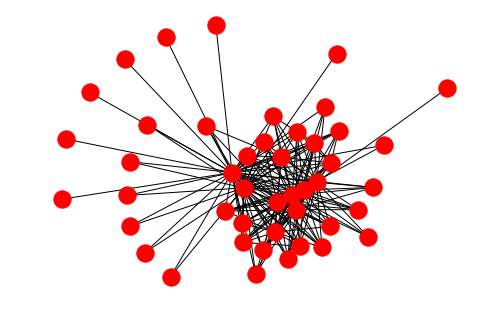

In [45]:
nx.draw(G)

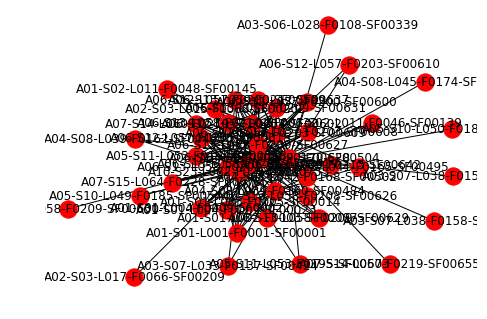

In [46]:
nx.draw(G, with_labels=True)

In [49]:
nx.draw(G,node_size=60,with_labels=True, font_size=8) 

In [51]:
# larger figure size
nx.draw(G, figsize=(20,20), node_size=60,with_labels=True, font_size=8) 

In [52]:
nx.algorithms.degree_centrality(G)

{'A01-S01-L001-F0001-SF00001': 0.1590909090909091,
 'A01-S01-L003-F0005-SF00014': 0.25,
 'A01-S01-L004-F0009-SF00023': 0.25,
 'A04-S08-L039-F0160-SF00484': 0.34090909090909094,
 'A04-S08-L043-F0170-SF00504': 0.9545454545454546,
 'A06-S13-L058-F0206-SF00619': 0.6136363636363636,
 'A06-S13-L058-F0207-SF00623': 0.6363636363636364,
 'A10-S23-L082-F0254-SF00733': 0.7272727272727273,
 'A01-S01-L002-F0003-SF00007': 0.20454545454545456,
 'A06-S13-L058-F0209-SF00627': 0.5454545454545454,
 'A06-S13-L058-F0209-SF00628': 0.6136363636363636,
 'A06-S12-L057-F0203-SF00609': 0.5227272727272727,
 'A01-S01-L004-F0009-SF00022': 0.1590909090909091,
 'A01-S02-L011-F0046-SF00139': 0.045454545454545456,
 'A01-S02-L011-F0048-SF00145': 0.045454545454545456,
 'A02-S03-L015-F0060-SF00202': 0.18181818181818182,
 'A06-S12-L057-F0201-SF00602': 0.38636363636363635,
 'A02-S03-L017-F0066-SF00209': 0.022727272727272728,
 'A03-S06-L028-F0108-SF00339': 0.022727272727272728,
 'A03-S07-L033-F0137-SF00424': 0.04545454545454

In [53]:
nx.density(G)

0.20909090909090908

In [54]:
nx.average_shortest_path_length(G)

1.8181818181818181

In [55]:
nx.average_degree_connectivity(G)

{7: 26.238095238095237,
 11: 21.545454545454547,
 15: 18.466666666666665,
 42: 8.80952380952381,
 27: 13.12962962962963,
 28: 12.678571428571429,
 32: 11.0625,
 9: 25.074074074074073,
 24: 14.25,
 23: 14.08695652173913,
 2: 36.357142857142854,
 8: 27.458333333333332,
 17: 17.176470588235293,
 1: 39.0,
 4: 30.0,
 6: 28.0,
 10: 23.8,
 5: 29.6}

In [60]:
nx.clustering(G)

{'A01-S01-L001-F0001-SF00001': 1.0,
 'A01-S01-L003-F0005-SF00014': 0.8909090909090909,
 'A01-S01-L004-F0009-SF00023': 0.8727272727272727,
 'A04-S08-L039-F0160-SF00484': 0.6857142857142857,
 'A04-S08-L043-F0170-SF00504': 0.18931475029036005,
 'A06-S13-L058-F0206-SF00619': 0.42165242165242167,
 'A06-S13-L058-F0207-SF00623': 0.3915343915343915,
 'A10-S23-L082-F0254-SF00733': 0.2963709677419355,
 'A01-S01-L002-F0003-SF00007': 1.0,
 'A06-S13-L058-F0209-SF00627': 0.4891304347826087,
 'A06-S13-L058-F0209-SF00628': 0.4188034188034188,
 'A06-S12-L057-F0203-SF00609': 0.4743083003952569,
 'A01-S01-L004-F0009-SF00022': 1.0,
 'A01-S02-L011-F0046-SF00139': 1.0,
 'A01-S02-L011-F0048-SF00145': 1.0,
 'A02-S03-L015-F0060-SF00202': 1.0,
 'A06-S12-L057-F0201-SF00602': 0.6691176470588235,
 'A02-S03-L017-F0066-SF00209': 0,
 'A03-S06-L028-F0108-SF00339': 0,
 'A03-S07-L033-F0137-SF00424': 1.0,
 'A03-S07-L038-F0157-SF00474': 0,
 'A03-S07-L038-F0158-SF00478': 0,
 'A04-S08-L041-F0165-SF00495': 1.0,
 'A04-S08-L04

In [61]:
sp = dict(nx.all_pairs_shortest_path(G))
sp['A10-S23-L082-F0254-SF00733']

{'A10-S23-L082-F0254-SF00733': ['A10-S23-L082-F0254-SF00733'],
 'A01-S01-L001-F0001-SF00001': ['A10-S23-L082-F0254-SF00733',
  'A01-S01-L001-F0001-SF00001'],
 'A01-S01-L002-F0003-SF00007': ['A10-S23-L082-F0254-SF00733',
  'A01-S01-L002-F0003-SF00007'],
 'A01-S01-L003-F0005-SF00014': ['A10-S23-L082-F0254-SF00733',
  'A01-S01-L003-F0005-SF00014'],
 'A01-S01-L004-F0009-SF00022': ['A10-S23-L082-F0254-SF00733',
  'A01-S01-L004-F0009-SF00022'],
 'A01-S01-L004-F0009-SF00023': ['A10-S23-L082-F0254-SF00733',
  'A01-S01-L004-F0009-SF00023'],
 'A01-S02-L011-F0046-SF00139': ['A10-S23-L082-F0254-SF00733',
  'A01-S02-L011-F0046-SF00139'],
 'A01-S02-L011-F0048-SF00145': ['A10-S23-L082-F0254-SF00733',
  'A01-S02-L011-F0048-SF00145'],
 'A02-S03-L015-F0060-SF00202': ['A10-S23-L082-F0254-SF00733',
  'A02-S03-L015-F0060-SF00202'],
 'A02-S03-L017-F0066-SF00209': ['A10-S23-L082-F0254-SF00733',
  'A02-S03-L017-F0066-SF00209'],
 'A03-S07-L033-F0137-SF00424': ['A10-S23-L082-F0254-SF00733',
  'A03-S07-L033-F013

In [62]:
end = time.time()

In [63]:
print((end - start)/60)

1094.138595366478


In [64]:
nx.algorithms.closeness_centrality(G)

{'A01-S01-L001-F0001-SF00001': 0.5432098765432098,
 'A01-S01-L003-F0005-SF00014': 0.5714285714285714,
 'A01-S01-L004-F0009-SF00023': 0.5714285714285714,
 'A04-S08-L039-F0160-SF00484': 0.6027397260273972,
 'A04-S08-L043-F0170-SF00504': 0.9565217391304348,
 'A06-S13-L058-F0206-SF00619': 0.7213114754098361,
 'A06-S13-L058-F0207-SF00623': 0.7333333333333333,
 'A10-S23-L082-F0254-SF00733': 0.7857142857142857,
 'A01-S01-L002-F0003-SF00007': 0.5569620253164557,
 'A06-S13-L058-F0209-SF00627': 0.6875,
 'A06-S13-L058-F0209-SF00628': 0.7213114754098361,
 'A06-S12-L057-F0203-SF00609': 0.676923076923077,
 'A01-S01-L004-F0009-SF00022': 0.5432098765432098,
 'A01-S02-L011-F0046-SF00139': 0.5057471264367817,
 'A01-S02-L011-F0048-SF00145': 0.5057471264367817,
 'A02-S03-L015-F0060-SF00202': 0.55,
 'A06-S12-L057-F0201-SF00602': 0.6197183098591549,
 'A02-S03-L017-F0066-SF00209': 0.4444444444444444,
 'A03-S06-L028-F0108-SF00339': 0.4943820224719101,
 'A03-S07-L033-F0137-SF00424': 0.5057471264367817,
 'A03-S